In [104]:

import pandas as pd
import osmnx as ox
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
from matplotlib import pyplot as plt
import spaghetti
import esda
import numpy as np
%matplotlib inline


# 1. Import data & data exploration & data cleaning

## 1.1 Understanding the column meaning


In [105]:
# data source: https://data.gov.uk/dataset/6efe5505-941f-45bf-b576-4c1e09b579a1/road-traffic-accidents
accident_2016 = pd.read_csv("../Data/Copy of Leeds_RTC_2016.csv", encoding='cp1252')
accident_2017 = pd.read_csv("../Data/Leeds_RTC_2017.csv")

In [106]:
accident_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2549 entries, 0 to 2548
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Reference Number     2549 non-null   object
 1   Grid Ref: Easting    2549 non-null   int64 
 2   Grid Ref: Northing   2549 non-null   int64 
 3   Number of Vehicles   2549 non-null   int64 
 4   Expr1                2549 non-null   object
 5   Accident Date        2549 non-null   object
 6   Time (24hr)          2549 non-null   int64 
 7   1st Road Class       2549 non-null   object
 8   Road Surface         2549 non-null   object
 9   Lighting Conditions  2549 non-null   object
 10  Weather Conditions   2549 non-null   object
 11  Casualty Class       2549 non-null   object
 12  Casualty Severity    2549 non-null   object
 13  Sex of Casualty      2549 non-null   object
 14  Age of Casualty      2549 non-null   int64 
 15  Type of Vehicle      2548 non-null   object
dtypes: int

In [107]:
accident_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Reference Number     2203 non-null   object
 1   Grid Ref: Easting    2203 non-null   int64 
 2   Grid Ref: Northing   2203 non-null   int64 
 3   Number of Vehicles   2203 non-null   int64 
 4   Accident Date        2203 non-null   object
 5   Time (24hr)          2203 non-null   int64 
 6   1st Road Class & No  2203 non-null   object
 7   Road Surface         2203 non-null   object
 8   Lighting Conditions  2203 non-null   object
 9   Weather Conditions   2203 non-null   object
 10  Type of Vehicle      2203 non-null   object
 11  Casualty Class       2203 non-null   object
 12  Casualty Severity    2203 non-null   object
 13  Sex of Casualty      2203 non-null   object
 14  Age of Casualty      2203 non-null   int64 
dtypes: int64(5), object(10)
memory usage: 258.3+ KB


In [108]:
accident_2018 = pd.read_csv("../Data/RTC 2018_Leeds.csv")
accident_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Accident Fields_Reference Number  1995 non-null   object
 1   Grid Ref: Easting                 1995 non-null   int64 
 2   Grid Ref: Northing                1995 non-null   int64 
 3   Number of Vehicles                1995 non-null   int64 
 4   Accident Date                     1995 non-null   object
 5   Time (24hr)                       1995 non-null   int64 
 6   1st Road Class                    1995 non-null   int64 
 7   1st Road Class & No               1995 non-null   object
 8   Road Surface                      1995 non-null   int64 
 9   Lighting Conditions               1995 non-null   int64 
 10  Weather Conditions                1995 non-null   int64 
 11  Local Authority                   1995 non-null   object
 12  Vehicle Fields_Refer

In [109]:
accident_2018.head()

,Accident Fields_Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,1st Road Class & No,Road Surface,Lighting Conditions,...,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Type of Vehicle,Casualty Fields_Reference Number,Casualty Veh No,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty
0,51B0230,433936,428874,1,11/01/2018,700,6,U,1,4,...,E08000035,51B0230,1,9,51B0230,1,3,3,2,87
1,51B0349,430076,433872,1,11/01/2018,855,6,U,2,1,...,E08000035,51B0349,1,11,51B0349,1,2,3,2,60
2,51B0349,430076,433872,1,11/01/2018,855,6,U,2,1,...,E08000035,51B0349,1,11,51B0349,1,2,3,2,51
3,51B0349,430076,433872,1,11/01/2018,855,6,U,2,1,...,E08000035,51B0349,1,11,51B0349,1,2,3,2,50
4,51B0349,430076,433872,1,11/01/2018,855,6,U,2,1,...,E08000035,51B0349,1,11,51B0349,1,2,3,2,51


In [110]:
print(accident_2018["Accident Fields_Reference Number"].equals(accident_2018["Vehicle Fields_Reference Number"]))
print(accident_2018["Casualty Fields_Reference Number"].equals(accident_2018["Vehicle Fields_Reference Number"]))

True
True


Accident data set of 2018 has 21 columns and non-null 1995 entries in total. "Grid Ref: Easting" and "Grid Ref: Northing" are geographical information. "Accident Fields_Reference Number", "Vehicle Fields_Reference Number" and "Casualty Fields_Reference Number" are same columns which won't be used.

**2018, useful columns**
"Grid Ref: Easting", <br/>
"Grid Ref: Northing", <br/>
"1st Road Class", <br/>
"Road Surface", <br/>
"Lighting Conditions", <br/>
"Weather Conditions", <br/>
"Type of Vehicle", <br/>
"Casualty Class", <br/>
"Casualty Severity", <br/>
"Sex of Casualty", <br/>
"Age of Casualty" 

In [111]:
accident_2019 = pd.read_csv("../Data/Traffic accidents_2019_Leeds.csv")
accident_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907 entries, 0 to 1906
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Reference Number     1907 non-null   object
 1   Grid Ref: Easting    1907 non-null   int64 
 2   Grid Ref: Northing   1907 non-null   int64 
 3   Number of Vehicles   1907 non-null   int64 
 4   Accident Date        1907 non-null   object
 5   Time (24hr)          1907 non-null   int64 
 6   1st Road Class       1907 non-null   int64 
 7   1st Road Class & No  1907 non-null   object
 8   Road Surface         1907 non-null   int64 
 9   Lighting Conditions  1907 non-null   int64 
 10  Weather Conditions   1907 non-null   int64 
 11  Local Authority      1907 non-null   object
 12  Vehicle Number       1907 non-null   int64 
 13  Type of Vehicle      1907 non-null   int64 
 14  Casualty Class       1907 non-null   int64 
 15  Casualty Severity    1907 non-null   int64 
 16  Sex of

In [112]:
accident_2019.head()

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,1st Road Class & No,Road Surface,Lighting Conditions,Weather Conditions,Local Authority,Vehicle Number,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty
0,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,1,E08000035,2,11,2,3,2,6
1,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,1,E08000035,2,11,2,3,1,9
2,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,1,E08000035,2,11,2,3,2,39
3,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,1,E08000035,2,11,2,3,1,5
4,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,1,E08000035,2,11,2,3,2,8


2019 is sightly different with 2018. 2019 doesn't has:<br/>
"Vehicle Fields_Reference Number", <br/>
"Casualty Fields_Reference Number", <br/>
"Casualty Veh No", <br/>

Besides, "Referene Number" need to be coordinate with 2018.

In [113]:
# drop unuseful columns and rename columns
accident_2016_clean = accident_2016.drop(["Number of Vehicles", "Expr1", "Time (24hr)", "1st Road Class", "Type of Vehicle"], axis = 1)
accident_2017_clean = accident_2017.drop(["Number of Vehicles", "Time (24hr)", "1st Road Class & No",  "1st Road Class & No" , "Type of Vehicle"], axis = 1)

accident_2018_clean = accident_2018.drop(["Number of Vehicles", "Time (24hr)", "1st Road Class & No", "1st Road Class",  "Local Authority", "Vehicle Fields_Reference Number", "Vehicle Number", "Casualty Fields_Reference Number", "Casualty Veh No", "Type of Vehicle"], axis = 1)
accident_2018_clean = accident_2018_clean.rename(columns = {"Accident Fields_Reference Number": "Reference Number"})
accident_2019_clean = accident_2019.drop(["Number of Vehicles", "Time (24hr)",  "1st Road Class", "Vehicle Number", "Local Authority", "1st Road Class & No", "Type of Vehicle"], axis = 1)

# Concat data
accident_concat = pd.concat([accident_2016_clean, accident_2017_clean, accident_2018_clean, accident_2019_clean]).reset_index(drop = True)


One reference number may has several rows due to more than one casualty in the accident. So I need to drop duplicate reference number by transfer "Age of Casualty" into a new variable "Number of Casualty". After this calculation, I only care about the number of casualty in an accident instead of the sex and age.

In [151]:
# Count number of casualty in each accident
ref_count = accident_concat.value_counts(subset = ["Reference Number"])
# Prepare to join the count number with dataframe
count_tmp = ref_count.to_frame("Casualty Count").reset_index()
# Join
accident_concat_count = pd.merge(accident_concat, count_tmp, how = "left", on = "Reference Number")
accident_concat_count = accident_concat_count.drop(["Age of Casualty", "Sex of Casualty", "Casualty Class", "Casualty Severity"], axis = 1)
accident_concat_count = accident_concat_count.drop_duplicates().reset_index(drop = True)  
# accident_concat_count.groupby("Reference Number").filter(lambda x: len(x) > 1)    # check if there are duplicated rows

In [152]:
accident_concat_count[["day", "month", "year"]] = accident_concat_count["Accident Date"].str.split("/", expand=True)

In [357]:
accident_concat_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6635 entries, 0 to 6634
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Reference Number     6635 non-null   object  
 1   Grid Ref: Easting    6635 non-null   int64   
 2   Grid Ref: Northing   6635 non-null   int64   
 3   Accident Date        6635 non-null   object  
 4   Road Surface         6635 non-null   object  
 5   Lighting Conditions  6635 non-null   object  
 6   Weather Conditions   6635 non-null   object  
 7   Casualty Count       6635 non-null   int64   
 8   day                  6635 non-null   object  
 9   month                6635 non-null   object  
 10  year                 6635 non-null   object  
 11  geometry             6635 non-null   geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 622.2+ KB


In [154]:
accident_gdf = gpd.GeoDataFrame(accident_concat_count, crs = "EPSG:27700", 
    geometry = [Point(xy) for xy in zip(accident_concat_count["Grid Ref: Easting"], accident_concat_count["Grid Ref: Northing"])]
)

In [157]:
accident_gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

# Task A: Contruct and investigate the road network

Approximate area is 1155073.3984221038 square meters


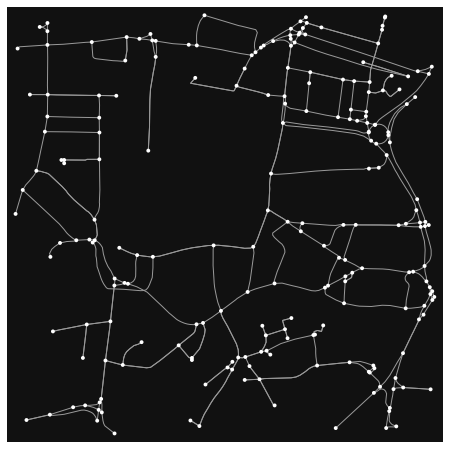

In [198]:
# get bbox from point, this a a randomly selected point in the centre of leeds
north, south, east, west = ox.utils_geo.bbox_from_point((53.7965027791719, -1.5421249629493987), dist = 550)
# get the drive road graph by bbox
leeds_graph = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify = True)

# project map, from "EPSG:4326" to "EPSG:27700"
G_proj = ox.project_graph(leeds_graph, "EPSG:27700")
# check the sized area does our network cover in square meters
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print("Approximate area is {} square meters".format(graph_area_m))
fig, ax = ox.plot_graph(G_proj)

In [199]:
leeds_polygon = nodes_proj.unary_union.convex_hull
leeds_accidents = accident_gdf[accident_gdf.geometry.within(leeds_polygon)]

# Explore the characteristics of this road network
## Centrality measurement: 
1. degree, 2. closeness, 3. Betweenness
The graeter the betweennesm it means a point has more possibility to fall on the path which 
connect other points to control their communication. The frequency with which a point falls 
between # pairs of other points on the shortest paths connecting them\cite{zhang2015investigating}

## clustering coefficient
How close a node’s neighbor nodes are to be in a sub-network
If a network has a higher overall clustering coefficient, there tends to be more clusters t
hroughout the network. 

In this road graph, there are 220 nodes, 376 edges, and 196 intersections. And this graph is non planar. According to Freeman, L.C.(1978), the centrality of a graph can be measured in three ways: degree, closeness, and betweenness. The degree is defined as the number of other points to which a given point is adjacent. Looking into the whole graph, the average degree of this road graph is 3.4. Secondly, the closeness is a measure to determine the independence of a point in a graph. The average closeness of this road graph is around 0.0007, and the average clustering coefficiency is around 0.1183. Third, the betweenness is the frequency with which a point falls between pairs of other points on the shortest paths connecting them. (Zhang Y. et. al., 2015) The greater the betweenness it means a point has more possibility to fall on the path which connect other points to control their communication. The betweenness of this graph is 0.05. Overall, the centrality of this road graph is not that strong as we can tell from closeness and betweenness. This is because this area includes a shopping centre which takes a large amount of the space and making roads are less connected.



In [200]:
nx.check_planarity(leeds_graph)

(False, None)

In [201]:
print("Number of nodes in the network: {}".format(G_proj.number_of_nodes()))


Number of nodes in the network: 220


In [202]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist="euclidean")

D:\software\Anaconda\envs\msda2021\lib\site-packages\osmnx\stats.py:317: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)
D:\software\Anaconda\envs\msda2021\lib\site-packages\osmnx\stats.py:327: UserWarning: The `clean_intersects` and `tolerance` arguments have been deprecated and will be removed in a future release. Use the `clean_int_tol` argument instead.
  warnings.warn(msg)


{'n': 220,
 'm': 376,
 'k_avg': 3.418181818181818,
 'edge_length_total': 23603.430999999997,
 'edge_length_avg': 62.775082446808504,
 'streets_per_node_avg': 2.922727272727273,
 'streets_per_node_counts': {0: 0, 1: 24, 2: 10, 3: 149, 4: 33, 5: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.10909090909090909,
  2: 0.045454545454545456,
  3: 0.6772727272727272,
  4: 0.15,
  5: 0.01818181818181818},
 'intersection_count': 196,
 'street_length_total': 17898.534000000003,
 'street_segment_count': 293,
 'street_length_avg': 61.08714675767919,
 'circuity_avg': 1.0319969594699616,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 109,
 'node_density_km': 190.46408678490263,
 'intersection_density_km': 169.6861864083678,
 'edge_density_km': 20434.572410933913,
 'street_density_km': 15495.581514084233,
 'clean_intersection_density_km': 94.36629754342904}

In [203]:
more_stats = ox.stats.extended_stats(G_proj, ecc=True, bc=False, cc=True)
print("closeness_centrality_avg is: {}".format(more_stats["closeness_centrality_avg"]))
print("clustering_coefficient_avg is {}".format(more_stats["clustering_coefficient_avg"]))
print("diameter is: {}".format(more_stats["diameter"]))
max_node, max_cc = max(more_stats["closeness_centrality"].items(), key=lambda x: x[1])
 # returns the id for the node with max. closeness contrality, and the value for the centrality
print("Max closeness node is: {},  it's closeness contrality is {}".format(max_node, max_cc))
max_page_node, max_page = max(more_stats["pagerank"].items(), key=lambda x: x[1])
print("Max pagerank node is: {},  it's pagerank is {}".format(max_page_node, max_page))

D:\software\Anaconda\envs\msda2021\lib\site-packages\osmnx\stats.py:405: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


closeness_centrality_avg is: 0.0007383968654491469
clustering_coefficient_avg is 0.11833333333333326
diameter is: 3151.79
Max closeness node is: 26298426,  it's closeness contrality is 0.0011082099265052232
Max pagerank node is: 26298435,  it's pagerank is 0.018487407623700443


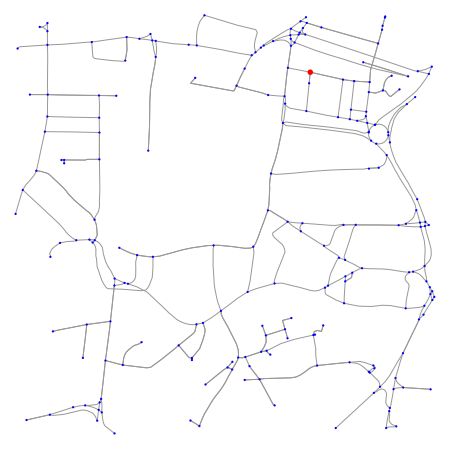

In [204]:
# In the selected area of centre leeds, the nodes with the highest closeness centrality has 0.7% possibility
# of all other nodes close to it. We can plot it. Also we can plot node with max page rank
nc = ['r' if node==max_node else 'b' for node in G_proj.nodes()]
ns = [30 if node==max_node else 5 for node in G_proj.nodes()]
fig, ax = ox.plot.plot_graph(G_proj, bgcolor='w', node_size=ns, node_color=nc, node_zorder=2)

## Calculate and visualize node centrality

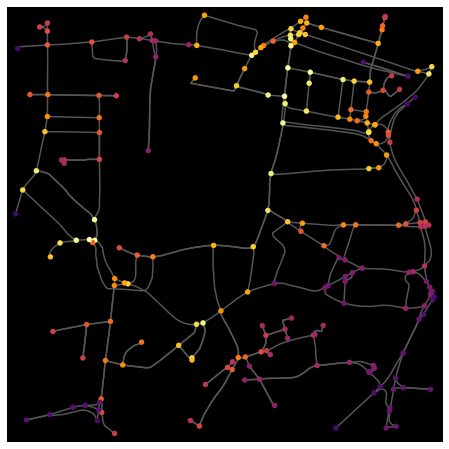

In [205]:
# node closeness centrality
node_centrality = nx.closeness_centrality(G_proj)
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G_proj.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G_proj, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

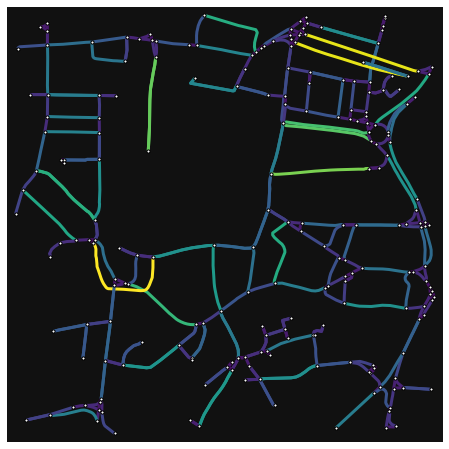

In [206]:
# show the strictly simplified network with edges colored by network length
ec = ox.plot.get_edge_colors_by_attr(G_proj, attr='length')
fig, ax = ox.plot.plot_graph(G_proj, node_color='w', node_edgecolor='k', node_size=10, 
                        node_zorder=3, edge_color=ec, edge_linewidth=3)

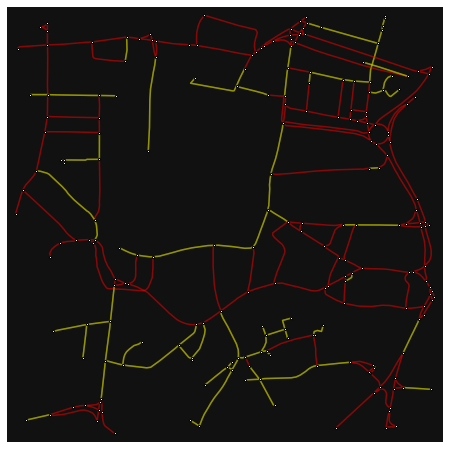

In [207]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'y' for u, v, key, data in G_proj.edges(keys=True, data=True)]
fig, ax = ox.plot.plot_graph(G_proj, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                             edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

# Calculate and visualize edge centrality

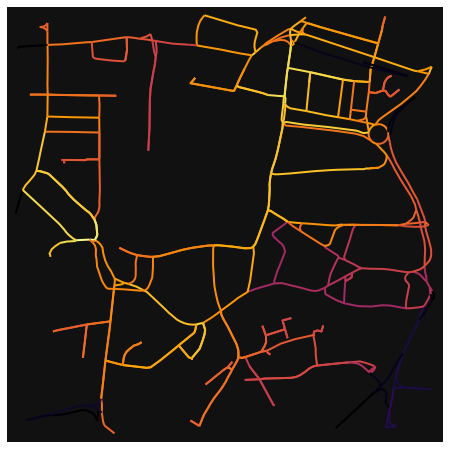

In [209]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G_proj))
nx.set_edge_attributes(G_proj, edge_centrality, "edge_centrality")
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G_proj, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G_proj, edge_color=ec, edge_linewidth=2, node_size=0)

## Calculate and visualize betweenness centrality


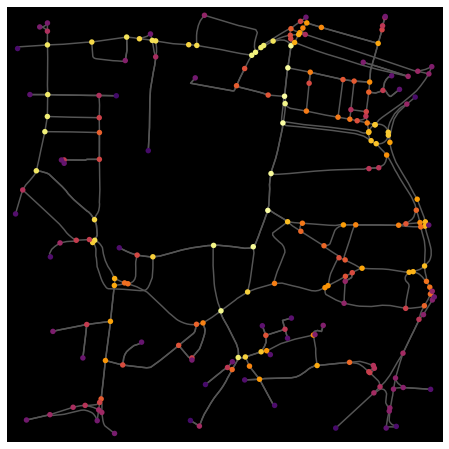

In [210]:
# node closeness centrality
node_bet_centrality = nx.betweenness_centrality(nx.DiGraph(G_proj))
# plot it
df = pd.DataFrame(data=pd.Series(node_bet_centrality).sort_values(), columns=['betw'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G_proj.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G_proj, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

In [211]:
df["betw"].mean()

0.057702670794916616

# Task B

In [212]:
graph_with_geometries = list(G_proj.edges(data=True))
# Iterate through the edges and, where missing, add a geometry attribute
# with the line between start and end nodes
x_values = nx.get_node_attributes(G_proj, 'x')
y_values = nx.get_node_attributes(G_proj, 'y')

for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

In [331]:
# # Drop the start and end nodes, as we will construct a new Spaghetti network
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = gpd.GeoDataFrame(pd.DataFrame(road_lines))
leeds_points_graph = spaghetti.Network(in_data = roads_geodataframe)
# Getting a pandas dataframe for the edges
vertice_df, arcs_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)



In [309]:
len(leeds_accidents)  # there are round 293 accidents in the selected areas

293

In [310]:
leeds_accidents.groupby(["year"]).size()
# As we can see, the number of accidents each year in the selected area is decreasing? Why? The reason will be elaborate in Task c

year
2016    92
2017    82
2018    60
2019    59
dtype: int64

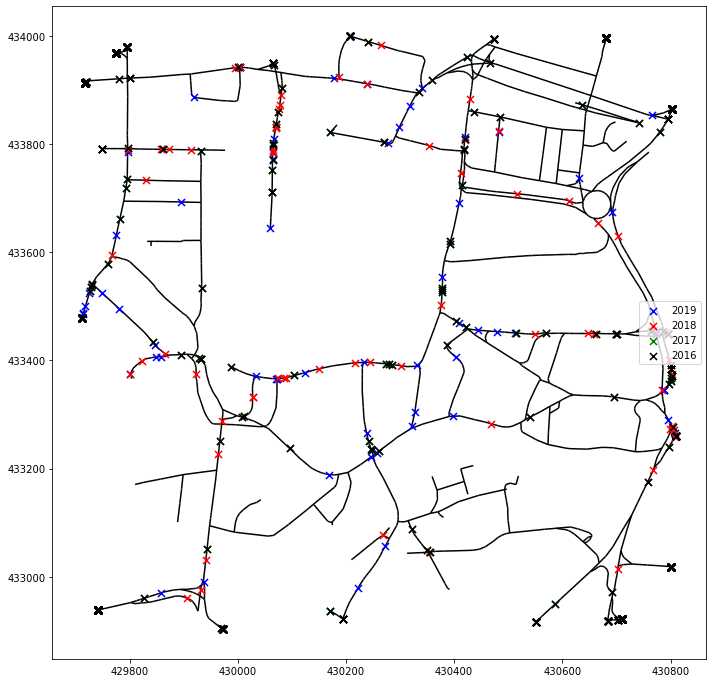

In [217]:
# Show the network
base_network = arcs_df.plot(color="k", zorder=0, figsize =(12, 12))

# Snap the centre leeds located accidents of 2019
leeds_points_graph.snapobservations(gpd.GeoDataFrame(accident_gdf.loc[accident_gdf["year"] == "2019"]["geometry"]), 'accidents_2019', attribute=True)
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_crimes_2019 = spaghetti.element_as_gdf(leeds_points_graph, pp_name='accidents_2019', snapped=True, arcs = True)

# Snap the centre leeds located accidents of 2018
leeds_points_graph.snapobservations(gpd.GeoDataFrame(accident_gdf.loc[accident_gdf["year"] == "2018"]["geometry"]), 'accidents_2018', attribute = True)
snapped_crimes_2018 = spaghetti.element_as_gdf(leeds_points_graph, pp_name='accidents_2018', snapped=True, arcs = True)

# Snap the centre leeds located accidents of 2017
leeds_points_graph.snapobservations(gpd.GeoDataFrame(accident_gdf.loc[accident_gdf["year"] == "2017"]["geometry"]), 'accidents_2017', attribute = True)
snapped_crimes_2017 = spaghetti.element_as_gdf(leeds_points_graph, pp_name='accidents_2017', snapped=True, arcs = True)

# Snap the centre leeds located accidents of 2016
leeds_points_graph.snapobservations(gpd.GeoDataFrame(accident_gdf.loc[accident_gdf["year"] == "2016"]["geometry"]), 'accidents_2016', attribute = True)
snapped_crimes_2016 = spaghetti.element_as_gdf(leeds_points_graph, pp_name='accidents_2017', snapped=True, arcs = True)

# Plot these on the road network
snapped_crimes_2019.plot(color="b", marker="x", markersize=50, zorder=1, ax=base_network, label = "2019")
snapped_crimes_2018.plot(color="r", marker="x", markersize=50, zorder=1, ax=base_network, label = "2018")
snapped_crimes_2017.plot(color="g", marker="x", markersize=50, zorder=1, ax=base_network, label = "2017")
snapped_crimes_2016.plot(color="k", marker="x", markersize=50, zorder=1, ax=base_network, label = "2016")
plt.legend(loc='right')
plt.show()

In [332]:
leeds_points_graph.snapobservations(gpd.GeoDataFrame(leeds_accidents["geometry"]), 'accidents_all', attribute=True)

In [230]:
# check the number connected components in the network.
print("The number connected components in the network: {}".format(leeds_points_graph.network_n_components))
print("Whether each component of the network is an isolated ring: {}".format(leeds_points_graph.network_component_is_ring[0]))
arcs = len(leeds_points_graph.network_component2arc[leeds_points_graph.network_component_labels[0]])
print("How many network arcs are associated with the component: {}".format(arcs))
print("How many vertices are in the network: {}".format(len(leeds_points_graph.vertex_coords)))


The number connected components in the network: 1
Whether each component of the network is an isolated ring: False
How many network arcs are associated with the component: 1303
How many vertices are in the network: 1230


In [224]:
# Show the point patterns associated with the network
# accidents is the add up accidents through 2016 and 2019
leeds_points_graph.pointpatterns.keys()

dict_keys(['accidents_2019', 'accidents_2018', 'accidents_2017', 'accidents_2016', 'accidents_all'])

In [382]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents_all"],
    nsteps=100, permutations=99
)

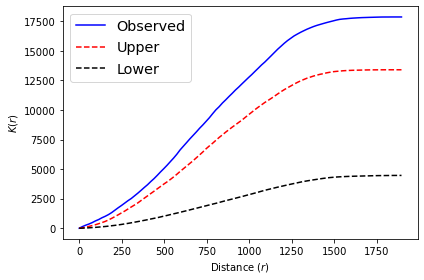

In [383]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()
plt.show()

In [ ]:
# The plot result shows that the accident distribution is not 
# random because the actual line is higher than upper boundary

In [384]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents_all']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

In [385]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

In [386]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [387]:
moran = esda.moran.Moran(values, weights)
moran.I

0.10562399382427944

In [389]:
# # Null hypothesis: spatial randomness
# Though Moran.I is so close to 0, p-value=0.001<0.05 &  z is positive so we can reject null hypotheis,
# We should say the number of accidents on one road has correlation with it's connected roads
print("p_value: {}".format(moran.p_sim)) 
print("z_score: {}".format(moran.z_sim))



p_value: 0.001
z_score: 4.22716176877379


In [261]:
moran.EI
moran.EI_sim

print("moran.EI: {}".format(moran.EI))
print("moran.EI_sim: {}".format(moran.EI_sim))

moran.EI: -0.0007680491551459293
moran.EI_sim: -0.001296599344252995


In [259]:
moran.z_norm
moran.z_sim

0.48932219244011693

# Task B.3

In [361]:
# select intersection location
nodes_list = [(item[1]["x"], item[1]["y"]) for item in list(G_proj.nodes(data=True))]
# 220 intersection, then we need to calculate the distance between snapped nodes and intersections

220

In [371]:
# this is inspired by intersection_count(G=None, min_streets=2) function is osmnx.stat module
from osmnx.stats import streets_per_node
spn = streets_per_node(G_proj)
node_ids = set(G_proj.nodes)
ss = [count >= 2 and node in node_ids for node, count in spn.items()]  # 2 is the default property in intersection_count function
is_intersection_index = [i for i in range(len(ss)) if ss[i]]

intersection_list = []
for index in is_intersection_index:
    intersection_list.append(nodes_list[index])

In [372]:
len(intersection_list)  # finally, we got 196 intersections

196

In [373]:
# store intersection location as geo dataframe
intersectrion_df = pd.DataFrame(intersection_list, columns =['x', 'y'])
intersection_loc_df = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(
    intersectrion_df.x, intersectrion_df.y)])

In [374]:
# snap intersection on the map
leeds_points_graph.snapobservations(intersection_loc_df, 'intersection', attribute=True)

In [375]:
cost_matrix = leeds_points_graph.allneighbordistances(
    sourcepattern=leeds_points_graph.pointpatterns["accidents_all"],
    destpattern=leeds_points_graph.pointpatterns["intersection"],
)

In [376]:
type(cost_matrix)

numpy.ndarray

In [377]:
cost_matrix.shape  # 293 accidents, 220 intersection

(293, 196)

In [378]:
# set threshhold, if distance is less than 20 meters, 
# then we can say this accidents happen near the intersection.
# if the accident is within the threshold, the give a flag = 999999
cost_matrix[cost_matrix <= 20] = 999999

In [379]:
# convert numpy ndarry to dataframe
numpy_df = pd.DataFrame(cost_matrix)

In [390]:
len(numpy_df.loc[(numpy_df == 999999).any(axis=1)])
# we can see there are 150 rows have flags,
# which means 154 of 293 accidents are nearer to intersections.
# This implies it's not true accidents are tend to happen near intersection than along roads

150